In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
df = pd.read_csv('sample_response_times.csv', delimiter=';')

In [4]:
df

,rt,choice,condition
0,0.477,1.0,1.0
1,0.600,1.0,1.0
2,0.500,0.0,1.0
3,0.416,1.0,1.0
4,0.435,1.0,1.0
...,...,...,...
295,0.528,0.0,2.0
296,0.621,0.0,2.0
297,0.480,1.0,2.0
298,0.693,1.0,2.0


In [31]:
def visualize_data(data, figsize=(10, 5)):
    """Helper function to visualize a simple response time data set."""

    f, axarr = plt.subplots(1, 2, figsize=figsize)
    
    # Histogram of response times
    sns.histplot(
        data[:, 0][data[:, 1] == 1], ax=axarr[0], color='#AA0000', alpha=0.8, lw=2, label=f'Response 1')
    sns.histplot(
        data[:, 0][data[:, 1] == 0], ax=axarr[0], color='#0000AA', alpha=0.8, lw=2, label=f'Response 0')

    # Barplot of categorical responses
    response, frequency = np.unique(data[:, 1], return_counts=True)
    sns.barplot(x=response.astype(np.int32), y=frequency, ax=axarr[1], alpha=0.8, color='#00AA00')

    # Labels and embelishments
    axarr[0].set_xlabel('Response time (s)', fontsize=16)
    axarr[0].legend(fontsize=16)
    axarr[0].set_ylabel('Count', fontsize=16)
    axarr[1].set_xlabel('Response', fontsize=16)
    axarr[1].set_ylabel('Frequency', fontsize=16)
    for ax in axarr:
        sns.despine(ax=ax)
        ax.grid(alpha=0.1, color='black')

    f.suptitle('Data Summary', fontsize=18)

    f.tight_layout()

In [8]:
data = df.to_numpy()

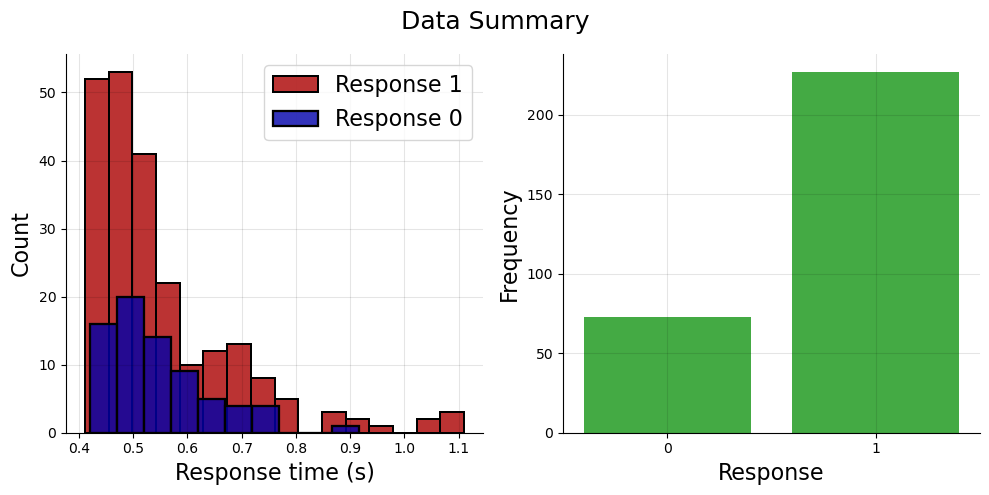

In [32]:
visualize_data(data)

In [35]:
# Prepare data in Stan friendly format
data_dict = {
    'y': data[:, 0], 
    'choice': data[:, 1].astype(int),
    'condition': data[:, 2].astype(int),
    'N': data.shape[0]
}

In [38]:
# Compile model
with open('diffusion_model.stan') as f:
    program_code = f.read()

model = stan.build(program_code, data=data_dict)


Building...



Building: 29.1s, done.

In [39]:
# Posterior inference using MCMC
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (202/14000)
Sampling:   2% (301/14000)
Sampling:   3% (401/14000)
Sampling:   4% (501/14000)
Sampling:   4% (601/14000)
Sampling:   5% (701/14000)
Sampling:   6% (801/14000)
Sampling:   6% (901/14000)
Sampling:   7% (1001/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (1900/14000)
Sampling:  14% (2000/14000)
Sampling:  15% (2100/14000)
Sampling:  16% (2200/14000)
Sampling:  16% (2300/14000)
Sampling:  17% (2400/14000)
Sampling:  18% (2500/14000)
Sampling:  19% (2600/14000)
Sampling:  19% (2700/14000)
Sampling:  20% (2800/14000)
Sampling:  21% (2900/14000)
Sampling:  21% (3000/14000)
Sampling:  22% (3101/14000)
Sampling:  23% (3201/14000

In [41]:
# Extract samples
df = fit.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,v1,a1,beta1,tau1,v2,a2,beta2,tau2
draws,,,,,,,,,,,,,,,
0,157.784062,0.984783,0.372629,3.0,7.0,0.0,-154.119417,2.337923,0.960071,0.595672,0.400032,1.366887,0.802037,0.431161,0.405722
1,159.632891,0.766231,0.355769,3.0,15.0,0.0,-156.777321,2.351044,0.970367,0.627646,0.400558,0.406470,0.830854,0.473000,0.406326
2,161.662761,0.924940,0.310790,4.0,15.0,0.0,-158.594488,2.028140,0.878505,0.643780,0.402163,0.903151,0.825471,0.428921,0.400315
3,159.396494,1.000000,0.291458,3.0,7.0,0.0,-154.198332,2.371143,0.904127,0.641865,0.403277,0.352798,0.829637,0.472600,0.404151
4,160.414339,0.975431,0.372629,3.0,15.0,0.0,-155.275765,2.343153,0.943285,0.633993,0.396507,0.962149,0.821195,0.453655,0.404313


In [42]:
# Posterior summary statistics
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v1,2.199,0.301,1.638,2.775,0.004,0.003,7072.0,6925.0,1.0
a1,0.913,0.049,0.827,1.009,0.001,0.000,8415.0,7045.0,1.0
beta1,0.613,0.036,0.545,0.681,0.000,0.000,6212.0,6158.0,1.0
tau1,0.400,0.004,0.393,0.406,0.000,0.000,6926.0,6122.0,1.0
v2,0.761,0.215,0.369,1.178,0.002,0.002,8511.0,5578.0,1.0
a2,0.819,0.032,0.761,0.880,0.000,0.000,7273.0,6258.0,1.0
beta2,0.449,0.026,0.402,0.500,0.000,0.000,8831.0,7457.0,1.0
tau2,0.404,0.004,0.396,0.410,0.000,0.000,7440.0,5634.0,1.0


/home/denicd/miniconda3/envs/stan/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


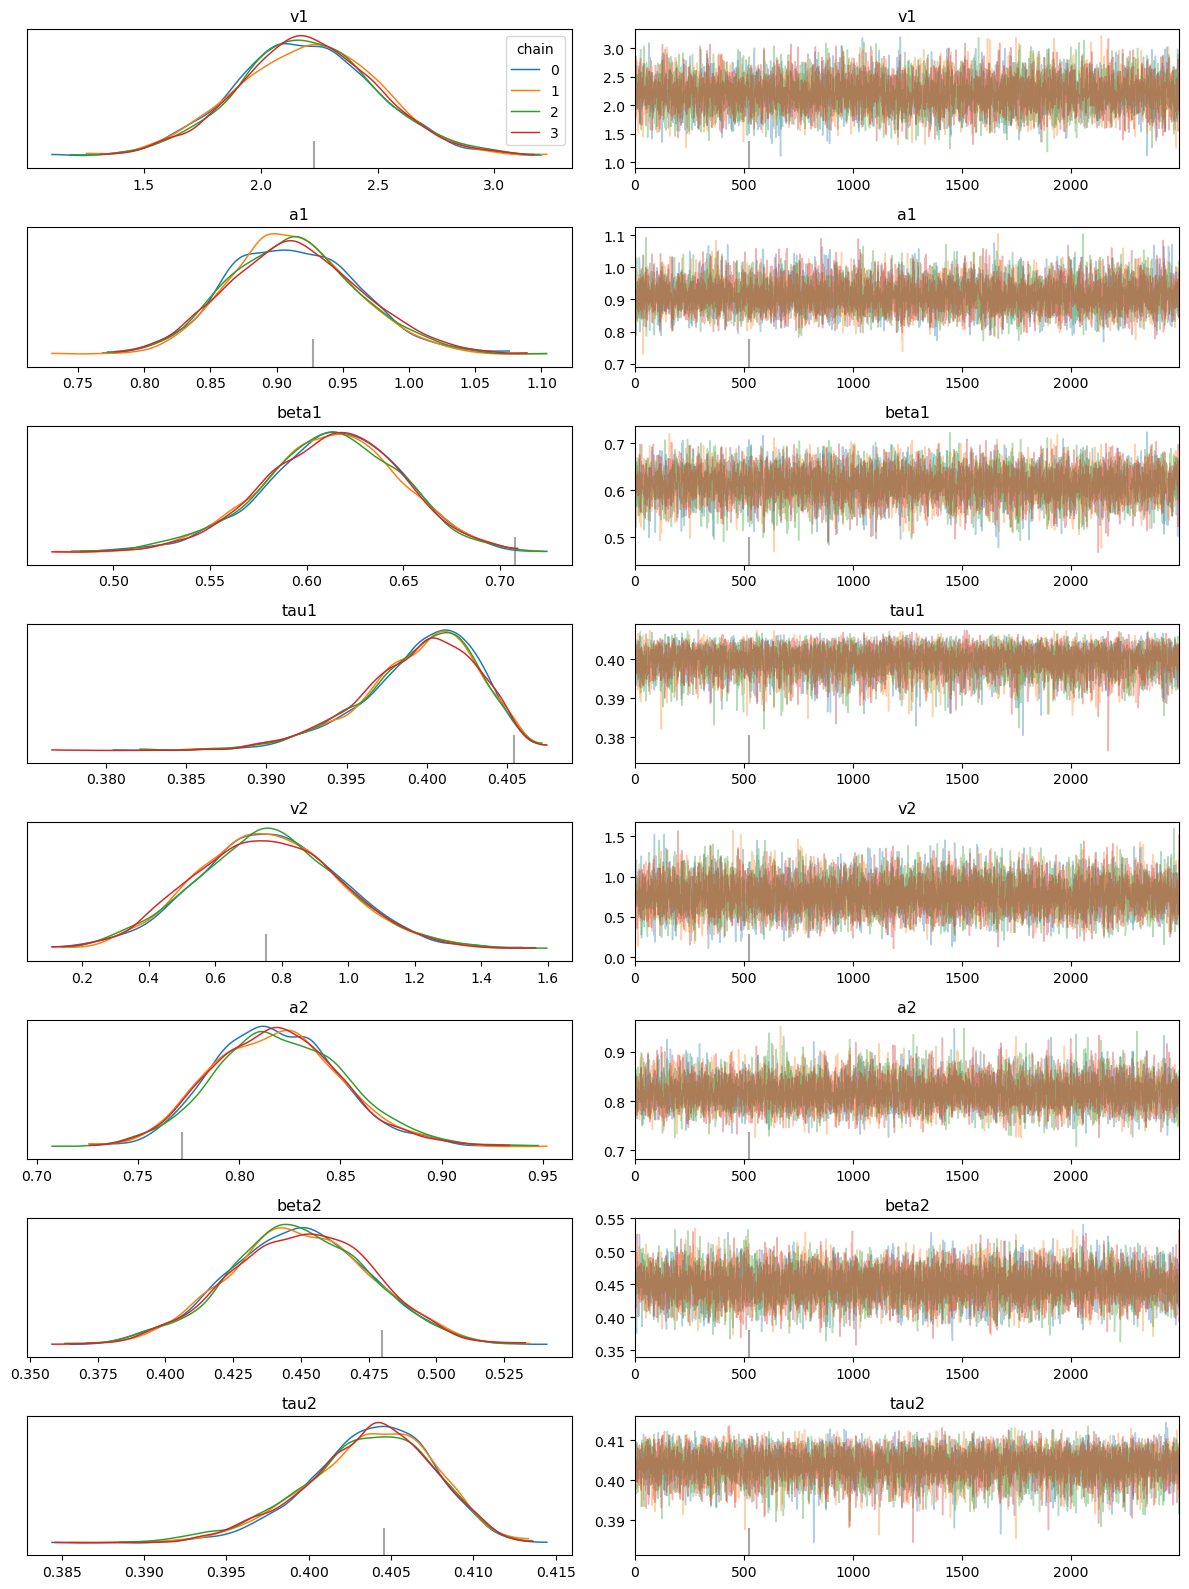

In [43]:
# Traceplots 
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

# Which condition is the difficult one?
The parameter that best reflects task difficulty is the drift rate. The higher the drift rate, the easier the task because the participant is moving towards a decision faster. The condition with the higher drift rate was condition 1, so this must be the easy condition, and condition 2 must correspond to the difficult condition.

# Convergence and Efficiency:
Firstly, we see that the values of the parameters all fall within the 94% highest density interval. Next, we see that r_hat is 1 for every parameter, thus, the model converges. Lastly, we see that every parameter has an effective sample size of less than 10000, which means the model is efficient because we used 4 chains with 2500 samples each.